## Прогноз гео(не)зависимости рубрик для данных 2GIS

In [1]:
data<-read.csv("Data_Projects.csv", sep=";", dec=",")

- AddressCount – количество кликов в адреса и/или входы.
- CallsCount – количество звонков в организации.
- ClicksCount – количество кликов в организации.
- FirmsCount – количество организаций в той или иной сфере.
- GeoPart – доля трафика с карты.
- MobilePart – доля трафика с мобильных продуктов.
- UsersCount – количество уникальных пользователей, которые совершали какие–то действия в данной сфере – открывали карточки организаций, тыкали во вход/адрес звонок и т.д.
- Distance – Медианная дистанция от пользователя до организации при совершении клика.
- IsGeo – признак геозависимой сферы (1 – геозависимая сфера; 0 – геонезависимая сфера (по экспертной разметке).

#### Подготовим данные

In [2]:
str(data)

'data.frame':	79 obs. of  9 variables:
 $ AddressCount: int  156 17 78 14 111 53 18 9 56 371 ...
 $ CallsCount  : int  20 37 56 70 90 96 137 150 153 176 ...
 $ ClicksCount : int  1903 258 1956 378 4089 1669 373 563 1366 5913 ...
 $ FirmsCount  : int  176 20 185 19 90 162 26 15 56 31 ...
 $ GeoPart     : num  0.416 0.212 0.349 0.319 0.556 ...
 $ MobilePart  : num  0.536 0.431 0.477 0.464 0.491 ...
 $ UsersCount  : int  1125 157 1195 206 2934 991 180 265 613 3981 ...
 $ Distance    : num  750 2289 1423 3397 1577 ...
 $ IsGeo       : int  1 0 1 0 1 0 0 0 0 0 ...


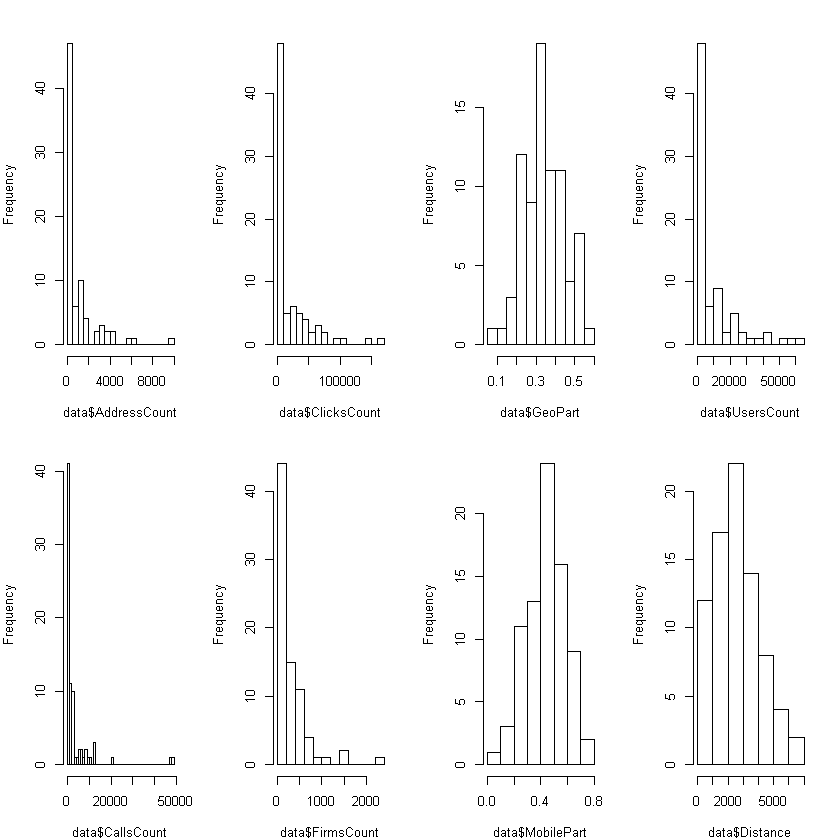

In [3]:
par(mfcol=c(2,4), mar=c(4,4,2,2))
hist(data$AddressCount, breaks="FD", main="")
hist(data$CallsCount, breaks="FD", main="")
hist(data$ClicksCount, breaks="FD", main="")
hist(data$FirmsCount, breaks="FD", main="")
hist(data$GeoPart, breaks="FD", main="")
hist(data$MobilePart, breaks="FD", main="")
hist(data$UsersCount, breaks="FD", main="")
hist(data$Distance, breaks="FD", main="")

Можно невооруженным глазом подметить, что AddressCount, CallsCount, ClicksCount, FirmsCount, UsersCount близки к логнормальному распределению. Тогда как GeoPart, MobilePart, Distance имеют куполообразное распределение с некоторой асимметрией и признаками смеси в данных. Distance явно асимметричен для нормального. Все признаки (за исключением IsGeo) представлены в метрических шкалах, поэтому они все пригодны для дальнейшего анализа стандартными методами. Однако логнормально-распределенные признаки следует приблизить к нормальности, чтобы избежать смещенных оценок. Для этого прологарифмируем AddressCount, CallsCount, ClicksCount, FirmsCount, UsersCount.

In [4]:
data$AddressCount<-log10(data$AddressCount)
data$CallsCount<-log10(data$CallsCount)
data$ClicksCount<-log10(data$ClicksCount)
data$FirmsCount<-log10(data$FirmsCount)
data$UsersCount<-log10(data$UsersCount)
data$Distance<-log10(data$Distance)

Разобъем данные на тестовую и обучающую выборку в соотношении 20/80 в целях контроля качества моделей.

In [5]:
set.seed(101)
sample <- sample.int(n = nrow(data), size = floor(.80*nrow(data)), replace = F)
train <- data[sample, ]
test  <- data[-sample, ]

#### 1. Оцените, какие признаки вносят значимый вклад в разделение рубрик на геозависимые и геонезависимые, и оставьте для включения в модель только те, которые значимо дифференцируют рубрики.

Отбор значимых для классификации признаков проведем с помощью алгоритма Boruta. Данный алгоритм оценивает важность предикторов при помощи случайных перестановок их значений и по умолчанию использует метод случайного леса (random forest). 

In [7]:
library("Boruta")

In [8]:
set.seed(101)
br <- Boruta(IsGeo~.,data=train)
br

Boruta performed 99 iterations in 4.904129 secs.
 5 attributes confirmed important: AddressCount, Distance, GeoPart,
MobilePart, UsersCount;
 1 attributes confirmed unimportant: CallsCount;
 2 tentative attributes left: ClicksCount, FirmsCount;

Итак Boruta предлагает нам исключить CallsCount, а также сомневается в ClicksCount и FirmsCount. Исключим только CallsCount.

In [9]:
train <- train[,-2]

#### 2. Выберите две модели наиболее, на Ваш взгляд, подходящие для решения задачи классификации рубрик. Кратко (1-2 абзаца) обоснуйте свой выбор.

В качестве классификатора для бинарной зависимой переменной в практике достаточно распространены следующие методы:
- множественная логистическая регрессия
- дерево решений


На сегодняний день они являются достаточно простыми в реализации, но при этом дают лучшие результаты, чем наивный бейесовский классификатор.

#### 3. Постройте первую из двух выбранных моделей, кратко охарактеризуйте вклад отдельных признаков в "судьбу" рубрики: что "способствует" геозависимости, а что, напротив, освобождает рубрику от территориальной привязки?

Построим логистическую регрессиию, а также применим алгоритм пошагового исключения незначимых признаков step.

In [10]:
logit <- glm(IsGeo ~ ., data = train, family = binomial(link = 'logit'))
logit.step <- step(logit, trace = 0)
summary(logit.step)


Call:
glm(formula = IsGeo ~ ClicksCount + MobilePart + UsersCount + 
    Distance, family = binomial(link = "logit"), data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.2597  -0.4250  -0.1232   0.3882   2.2200  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)   
(Intercept)   14.378      7.440   1.933  0.05329 . 
ClicksCount  -10.712      5.176  -2.070  0.03848 * 
MobilePart     9.884      4.433   2.230  0.02578 * 
UsersCount    11.512      5.533   2.081  0.03745 * 
Distance      -5.854      2.000  -2.927  0.00342 **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 81.516  on 62  degrees of freedom
Residual deviance: 40.980  on 58  degrees of freedom
AIC: 50.98

Number of Fisher Scoring iterations: 6


Алгоритм step сошёлся на 6 шагах и сформировал модель, включающую 4 признака, значимых на уровне 95%. Логистическая регрессия не очень удачный выбор с точки зрения интерпретации влияния признаков, однако анализируя коэффициенты в модели можно сказать, что признаки MobilePart и UsersCount "способствуют" геозависимости, а ClicksCount и Distance - "освобождают" от территориальной привязки.

#### 4. Постройте вторую модель, сравните результат, полученный на разных моделях.

Построим классификатор на основе дерева решений.

In [23]:
library(rpart)
tree <- rpart(IsGeo ~ ., data = train, method = "class")

In [20]:
summary(tree)

Call:
rpart(formula = IsGeo ~ ., data = train, method = "class")
  n= 63 

          CP nsplit rel error    xerror      xstd
1 0.45454545      0 1.0000000 1.0000000 0.1719928
2 0.04545455      1 0.5454545 0.7272727 0.1570421
3 0.01000000      2 0.5000000 0.8636364 0.1655809

Variable importance
    Distance   MobilePart   FirmsCount      GeoPart AddressCount  ClicksCount 
          31           16           15           15           11           11 
  UsersCount 
           2 

Node number 1: 63 observations,    complexity param=0.4545455
  predicted class=0  expected loss=0.3492063  P(node) =1
    class counts:    41    22
   probabilities: 0.651 0.349 
  left son=2 (37 obs) right son=3 (26 obs)
  Primary splits:
      Distance     < 3.357408  to the right, improve=10.422860, (0 missing)
      MobilePart   < 0.471539  to the left,  improve= 9.247042, (0 missing)
      AddressCount < 2.695512  to the left,  improve= 6.706349, (0 missing)
      UsersCount   < 3.581387  to the left,  imp

In [13]:
tree$variable.importance/sum(tree$variable.importance)*100

Distance   MobilePart   FirmsCount      GeoPart AddressCount  ClicksCount 
   30.963740    15.742657    15.481870    14.849228    10.643847    10.643847 
  UsersCount 
    1.674813

Если мы обратим внимание на параметр Variable importance, который показывает относительную значимость каждого признака в разбиении, то можно сказать, что признак UsersCount следовало бы исключить. Тогда как Distance, MobilePart и FirmsCount играют важную роль в построении дерева.


#### 5. Коротко (на 1-2 абзаца) объясните различия в результате, если таковые будут выявлены.

Оценим качество классификаторов на основе ROC-кривых.

In [15]:
library(ROCR)

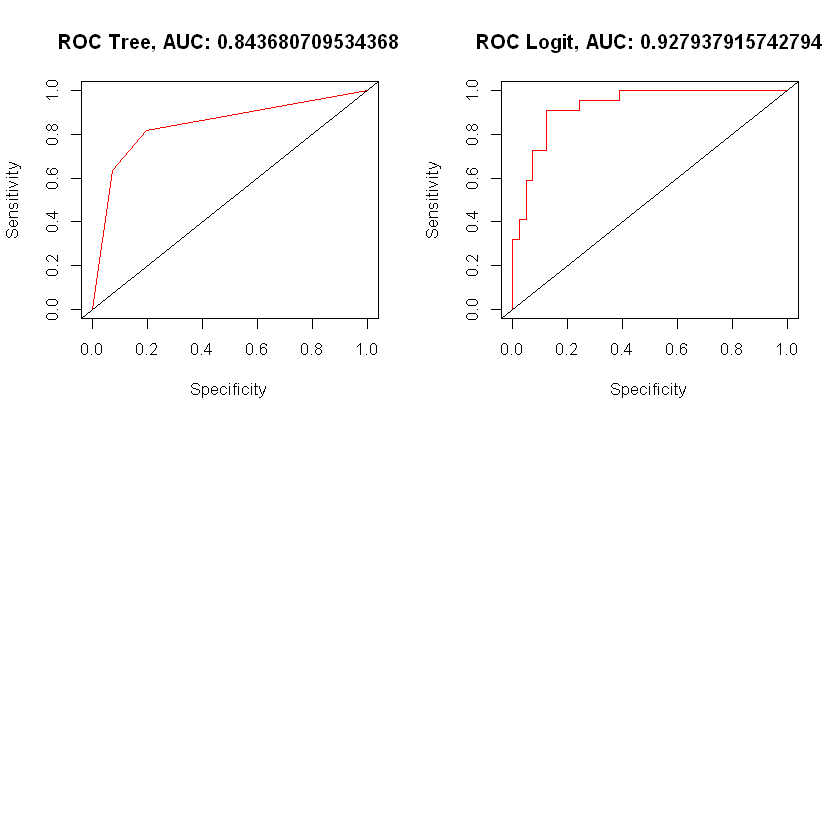

In [16]:
par(mfrow=c(2,2))

tree_pred <- predict(tree, type = "prob")[,2]
pred <- prediction(tree_pred, train$IsGeo) 
perf <- performance(pred, measure = "tpr", x.measure = "fpr")     
plot(perf, col=rainbow(7), main=paste("ROC Tree, AUC:",performance(pred, measure = "auc")@y.values),
     xlab="Specificity", ylab="Sensitivity")    
abline(0, 1) #add a 45 degree line

logit.step_pred <- predict(logit.step, type = "response")
pred <- prediction(logit.step_pred, train$IsGeo) 
perf <- performance(pred, measure = "tpr", x.measure = "fpr")     
plot(perf, col=rainbow(7), main=paste("ROC Logit, AUC:", performance(pred, measure = "auc")@y.values),
     xlab="Specificity", ylab="Sensitivity")    
abline(0, 1) #add a 45 degree line

Чем ближе ROC кривая к верхнему левому углу и больше площадь под ней (AUC), тем лучше качество модели. В нашем случае Logit показывает лучшие результаты.

#### 6. Постройте прогноз для нескольких (2-3) рубрик: в какой класс они попадут и с какой вероятностью?

Выполним прогноз для нашей тестовой выборки с помощью построенных моделей и оценим качество классификации.

In [17]:
tree_pred <- predict(tree, newdata = test, type = "class")
tree_p <- predict(tree, newdata = test, type = "prob")
logit.step_pred <- predict(logit.step, newdata = test, type = "response")

In [18]:
cbind(IsGeo = test$IsGeo, 
      Tree = ifelse(tree_pred == 1, 1 ,0), 
      Logit = ifelse(logit.step_pred > 0.5, 1, 0), 
      TreeP = round(tree_p[,2],2),
      LogitP = round(logit.step_pred,2))

,IsGeo,Tree,Logit,TreeP,LogitP
4,0,0,0,0.11,0.06
5,1,1,1,0.82,0.85
7,0,0,0,0.11,0.03
11,1,1,1,0.82,0.99
19,0,0,0,0.44,0.16
23,0,0,0,0.11,0.00
27,0,0,0,0.11,0.01
28,0,0,0,0.11,0.00
30,0,0,0,0.11,0.33
34,0,0,0,0.11,0.03


Ввиду того, что выборка у нас небольшая, качество классификации можно оценить невооруженным глазом.
Видно, что обе классификационных модели ошиблись только в одном из 16 тестовых значений, классифицированных экспертами (т.е. точность на уровне 94%).